In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
from utils import *
from sklearn.model_selection import train_test_split

from inception import EEGInception, InceptionDataset
from fish import FishNet, FishDataset
import numpy as np
import scipy
from tqdm.auto import tqdm

from scipy.signal import kaiserord, lfilter, firwin, freqz
import os
import copy

In [2]:
device="cuda"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

E=100

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def EANorm(X, R):
    R = np.linalg.inv(R)
    R = np.matmul(R, R)
    return np.matmul(R, X)

def getR(X):
    N = X.shape[0]
    R = np.zeros((X.shape[1], X.shape[1]))
    for x in X:
        R += np.matmul(x, x.T)/N
    return R

In [5]:
# X_train = np.load("../X_train.npy", mmap_mode='r')
# X_test = np.load("../X_test.npy", mmap_mode='r')
# y_train = np.load("../y_train.npy", mmap_mode='r')-1
# y_test = np.load("../y_test.npy", mmap_mode='r')-1


X_train = np.load("data/PHISYO__numberSub20_subIDtrain0_subIDtest8_band_13-Copy1.0_31.0_trainTestRandom.npy", mmap_mode='r')
y_train = np.load("data/PHISYO__numberSub20_subIDtrain0_subIDtest8_band_13-Copy1.0_31.0_trainTestRandom_label.npy", mmap_mode='r')
X_test = np.load("data/PHISYO__numberSub20_subIDtrain0_subIDtest8_band_13-Copy1.0_31.0_trainTestRandom_test.npy", mmap_mode='r')
y_test = np.load("data/PHISYO__numberSub20_subIDtrain0_subIDtest8_band_13-Copy1.0_31.0_trainTestRandom_label_test.npy", mmap_mode='r')

sample_rate = 250

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 10

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 8.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
X_train = lfilter(taps, 1.0, X_train)
X_test = lfilter(taps, 1.0, X_test)

In [6]:
X_train.shape

(3052, 22, 750)

In [7]:
X_test.shape

(576, 22, 750)

In [8]:
3052+576

3628

In [9]:
R = getR(X_train)
X_train = EANorm(X_train, R)
X_test = EANorm(X_test, R)
X_test, X_test, _, _ = normMat(X_test, X_test, 1)
X_train, X_train, _, _ = normMat(X_train, X_train, 1)
X_train, X_test, _, _ = normMat(X_train, X_test)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_tune_train, X_tune_val, y_tune_train, y_tune_val = train_test_split(X_test, y_test, test_size=0.1)

In [11]:
X_train.shape

(2746, 22, 750)

In [12]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as f

from torch.utils.data import Dataset, DataLoader

class ShallowEEG(nn.Module):
    def __init__(self, in_chans, in_length, no_classes):
        super(ShallowEEG, self).__init__()
        dummy = torch.zeros((1,1,in_chans, in_length))
        
        self.convtemp = nn.Conv2d(1, 40, (1, 25))
        init.xavier_uniform_(self.convtemp.weight)
        init.constant_(self.convtemp.bias, 0)
        
        self.convspat = nn.Conv2d(40, 40, (in_chans, 1))
        init.xavier_uniform_(self.convspat.weight)
        init.constant_(self.convspat.bias, 0)
        
        self.pool = nn.MaxPool2d((1, 75), stride=(1, 15))
        dummy = nn.Flatten()(self.pool(self.convspat(self.convtemp(dummy))))
        self.linear = nn.Linear(dummy.shape[-1], no_classes)
    
    def forward(self, data):
        data = f.relu(self.convtemp(data))
        data = f.relu(self.convspat(data))
        data = self.pool(data)
        data = nn.Flatten()(data)
        data = f.softmax(self.linear(data))
        return data
    
class DeepEEG(nn.Module):
    def __init__(self, in_chans, in_length, no_classes):
        super(DeepEEG, self).__init__()
        dummy = torch.zeros((1,1,in_chans, in_length))
        # Block 1
        self.convtemp = nn.Conv2d(1,  25, (1, 10))
        self.wbinit(self.convtemp)
        
        self.convspat = nn.Conv2d(25, 25, (in_chans, 1))
        self.wbinit(self.convspat)
        
        self.pool1 = nn.MaxPool2d((1, 3), stride=(1, 3))
        
        self.block1 = nn.Sequential(
            self.convtemp,
            self.convspat,
            self.pool1
        )
        dummy = self.block1(dummy)
        
        # Block 2
        self.conv2 = nn.Conv2d(25, 50, (1, 10))
        self.wbinit(self.conv2)
        
        self.pool2 = nn.MaxPool2d((1, 3), stride=(1, 3))
        
        self.block2 = nn.Sequential(
            self.conv2,
            nn.ReLU(),
            self.pool2
        )
        dummy = self.block2(dummy)
        
        # Block 3
        self.conv3 = nn.Conv2d(50, 100, (1,10))
        self.wbinit(self.conv3)
        
        self.pool3 = nn.MaxPool2d((1, 3), stride=(1, 3))
        
        self.block3 = nn.Sequential(
            self.conv3,
            nn.ReLU(),
            self.pool3
        )
        dummy = self.block3(dummy)
        
        # Block 4
        self.conv4 = nn.Conv2d(100, 200, (1,10))
        self.wbinit(self.conv4)
        
        self.pool4 = nn.MaxPool2d((1, 3), stride=(1, 3))
        
        self.block4 = nn.Sequential(
            self.conv4,
            nn.ReLU(),
            self.pool4
        )
        dummy = self.block4(dummy)
        
        # CLassifier
        dummy = nn.Flatten()(dummy)
        self.linear = nn.Linear(dummy.shape[-1], no_classes)
        
    
    def wbinit(self, layer):
        init.xavier_uniform_(layer.weight)
        init.constant_(layer.bias, 0)
    
    def forward(self, data):
        data = self.block1(data)
        data = self.block2(data)
        data = self.block3(data)
        data = self.block4(data)
        data = nn.Flatten()(data)
        data = f.softmax(self.linear(data))
        return data
        
    
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.X[idx]).unsqueeze(dim=0)
        y = self.y[idx]
        return X, y

In [13]:
trainset = EEGDataset(X_train, y_train)
valset = EEGDataset(X_val, y_val)
traintuneset = EEGDataset(X_tune_train, y_tune_train)
valtuneset = EEGDataset(X_tune_val, y_tune_val)

trainloader = DataLoader(trainset, batch_size=200)
valloader = DataLoader(valset, batch_size=200)
traintuneloader = DataLoader(traintuneset, batch_size=200)
valtuneloader = DataLoader(valtuneset, batch_size=200)

model = DeepEEG(in_chans = X_train.shape[1], in_length = X_train.shape[2], no_classes=3).to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, verbose=True)

loss_train = []
loss_val = []
acc_train = []
acc_val = []

E = 101
E_tune = 31

for e in tqdm(range(E)):
    model.train()
    train_loss = 0
    train_acc = 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fun(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(output, dim=1) == y).item()
    scheduler.step(train_loss)
    train_loss /= len(trainloader)
    train_acc /= len(trainset)
    
    val_loss = 0
    val_acc = 0
    with torch.inference_mode():
        for X, y in valloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = loss_fun(output, y)
            val_loss += loss.item()
            val_acc += torch.sum(torch.argmax(output, dim=1) == y).item()
    val_loss /= len(valloader)
    val_acc /= len(valset)
    
    if e%10==0:
        print(train_acc, val_acc)
        
#     # Fine tune
#         print("Fine-tuning")
#         finetune_model = copy.deepcopy(model)
#         finetune_optimizer = torch.optim.Adam(finetune_model.parameters(), lr=0.0001)
#         for etune in tqdm(range(E_tune)):
#             tune_train_acc = 0
#             tune_train_loss = 0
#             finetune_model.train()
#             for X, y in traintuneloader:
#                 X, y = X.to(device), y.to(device)
#                 output = finetune_model(X)
#                 loss = loss_fun(output, y)
#                 loss.backward()
#                 finetune_optimizer.step()
#                 tune_train_loss += loss.item()/len(traintuneloader)
#                 tune_train_acc += torch.sum(torch.argmax(output, dim=1) == y).item()/len(traintuneset)
#         with torch.inference_mode():
#             tune_val_acc = 0
#             tune_val_loss = 0
#             for X, y in valtuneloader:
#                 X, y = X.to(device), y.to(device)
#                 output = finetune_model(X)
#                 loss = loss_fun(output, y)
#                 tune_val_loss += loss.item()/len(valtuneloader)
#                 tune_val_acc += torch.sum(torch.argmax(output, dim=1) == y).item()/len(valtuneset)
#         print(tune_val_loss, tune_val_acc)
#         print("________________________________________________________")
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

  0%|          | 0/101 [00:00<?, ?it/s]

/tmp/ipykernel_16514/2941981507.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = f.softmax(self.linear(data))


0.4089584850691915 0.3660130718954248
0.6114348142753095 0.5424836601307189
0.6693372177713037 0.5522875816993464
0.7407137654770576 0.5784313725490197
0.7348871085214858 0.5718954248366013
0.7487254187909687 0.5392156862745098
0.7450837581937363 0.545751633986928
Epoch 00062: reducing learning rate of group 0 to 1.0000e-05.
0.7490895848506919 0.565359477124183
0.7490895848506919 0.5620915032679739
0.7490895848506919 0.5620915032679739
0.7490895848506919 0.5620915032679739


In [14]:
testset = EEGDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=64)

test_loss = 0
test_acc = 0
with torch.inference_mode():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = loss_fun(output, y)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(output, dim=1) == y).item()
test_loss /= len(testloader)
test_acc /= len(testset)

/tmp/ipykernel_16514/2941981507.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = f.softmax(self.linear(data))


In [15]:
test_loss

1.0514448881149292

In [16]:
test_acc

0.5

In [ ]:
0.4089584850691915 0.3660130718954248
0.6125273124544792 0.545751633986928
0.6693372177713037 0.5490196078431373
0.7396212672978878 0.5816993464052288
0.6951930080116533 0.5620915032679739
0.747632920611799 0.545751633986928
0.7494537509104151 0.5718954248366013
0.7498179169701383 0.5718954248366013
0.7498179169701383 0.5686274509803921
0.7498179169701383 0.5686274509803921
0.7498179169701383 0.5686274509803921

In [46]:
train_loss = np.array(loss_train)
val_loss = np.array(loss_val)
train_acc = np.array(acc_train)
val_acc = np.array(acc_val)

In [24]:
val_loss

0.9585143625736237

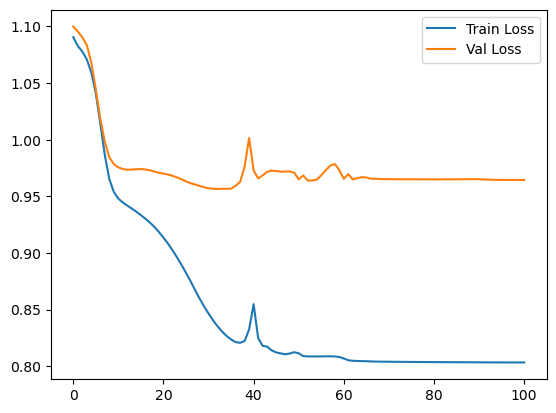

In [47]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.show()

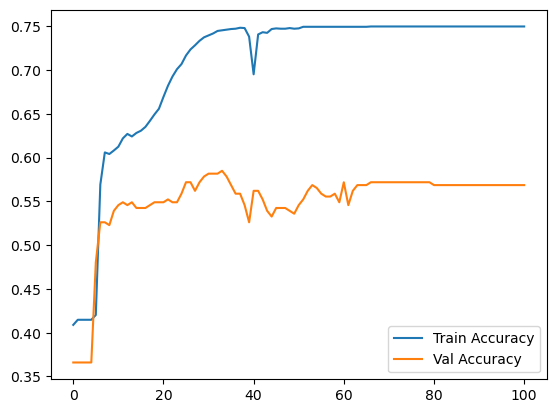

In [48]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.show()

In [18]:
pred = []
truth = []
with torch.inference_mode():
    for X, y in valloader:
        truth.append(y.detach().numpy())
        pred.append(torch.argmax(model(X.to(device)).cpu().detach(), dim=1).numpy())

/tmp/ipykernel_16390/2941981507.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = f.softmax(self.linear(data))


In [19]:
truth = np.array(np.concatenate(truth))
pred = np.array(np.concatenate(pred))

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

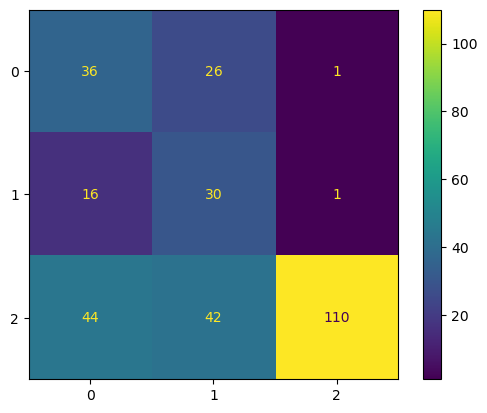

In [20]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(pred, truth)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
plt.plot(train_acc)

In [ ]:
trainset = FishDataset(X_train, y_train)
valset = FishDataset(X_val, y_val)
trainloader = DataLoader(trainset)
valloader = DataLoader(valset)

model = FishNet(in_chans = X_train.shape[1], n_classes=3).to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, verbose=True)

loss_train = []
loss_val = []
acc_train = []
acc_val = []

E = 201
E_tune = 31

for e in tqdm(range(E)):
    model.train()
    train_loss = 0
    train_acc = 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fun(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(output, dim=1) == y).item()
    scheduler.step(train_loss)
    train_loss /= len(trainloader)
    train_acc /= len(trainset)
    
    val_loss = 0
    val_acc = 0
    with torch.inference_mode():
        for X, y in valloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = loss_fun(output, y)
            val_loss += loss.item()
            val_acc += torch.sum(torch.argmax(output, dim=1) == y).item()
    val_loss /= len(valloader)
    val_acc /= len(valset)
    
    if e%10==0:
        print(train_acc, val_acc)

  0%|          | 0/201 [00:00<?, ?it/s]

/home/student5/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400430266/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,
/home/student5/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.41114348142753093 0.3660130718954248


In [18]:
train_loss = np.array(loss_train)
val_loss = np.array(loss_val)
train_acc = np.array(acc_train)
val_acc = np.array(acc_val)
test_loss = np.array(loss_test)
test_acc = np.array(acc_test)

NameError: name 'loss_test' is not defined

NameError: name 'test_acc' is not defined

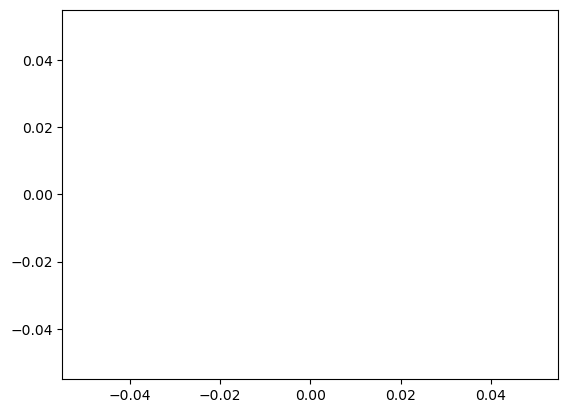

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_acc)
plt.plot(val_acc)
plt.plot(test_acc)

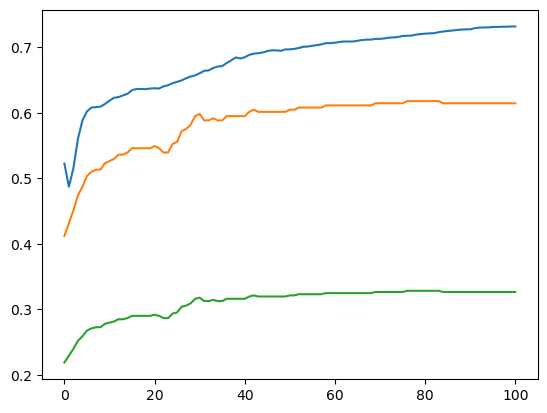

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_acc)
plt.plot(val_acc)
plt.plot(test_acc)

In [12]:
# np.save("Result/non aligned/inception/22/train_loss.npy", train_loss, allow_pickle=True)
# np.save("Result/non aligned/inception/22/val_loss.npy", val_loss, allow_pickle=True)
# np.save("Result/non aligned/inception/22/train_acc.npy", train_acc, allow_pickle=True)
# np.save("Result/non aligned/inception/22/val_acc.npy", val_acc, allow_pickle=True)

In [13]:
# Fine tune
print("Fine-tuning")
tunemodel = copy.deepcopy(model)
tuneoptimizer = torch.optim.Adam(tunemodel.parameters(), lr=0.0001)

for etune in tqdm(range(101)):
    tune_train_acc = 0
    tune_train_loss = 0
    model.train()
    for X, y in traintuneloader:
        X, y = X.to(device), y.to(device)
        tuneoptimizer.zero_grad()
        output = tunemodel(X)
        loss = loss_fun(output, y)
        loss.backward()
        tuneoptimizer.step()
        tune_train_loss += loss.item()/len(traintuneloader)
        tune_train_acc += torch.sum(torch.argmax(output, dim=1) == y).item()/len(traintuneset)
    print(tune_train_loss, tune_train_acc)
with torch.inference_mode():
    tune_val_acc = 0
    tune_val_loss = 0
    for X, y in valtuneloader:
        X, y = X.to(device), y.to(device)
        output = tunemodel(X)
        loss = loss_fun(output, y)
        tune_val_loss += loss.item()/lxen(valtuneloader)
        tune_val_acc += torch.sum(torch.argmax(output, dim=1) == y).item()/len(valtuneset)
print(tune_val_loss, tune_val_acc)

Fine-tuning


  0%|          | 0/101 [00:00<?, ?it/s]

1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334


/tmp/ipykernel_15013/2941981507.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  data = f.softmax(self.linear(data))


1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569778442 0.5208333333333334
1.0268994569

In [13]:
# torch.save(model, 'Result/non aligned/inception/22/model_e100.pt')